# 前言

## 技术框架环境介绍

**Apache Spark™ is a unified analytics engine for large-scale data processing.**
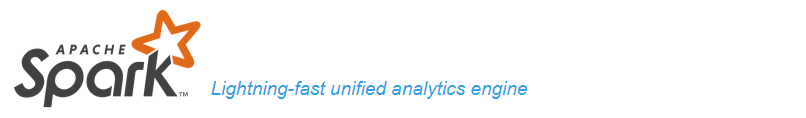

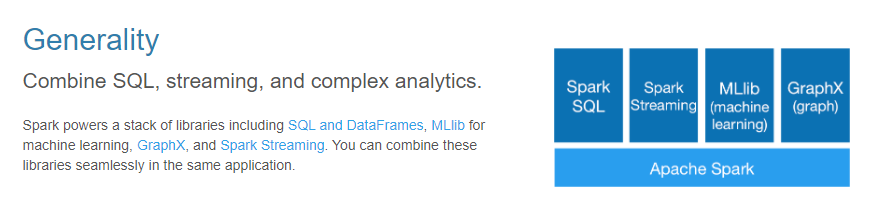

In [86]:
spark

## 开发环境

- Linux / Windows
- Python 3.6.x 
- Jupyter NoteBook [Anaconda3](https://mirrors.tuna.tsinghua.edu.cn/anaconda/archive/Anaconda3-2020.07-Windows-x86_64.exe)

**Step 1**
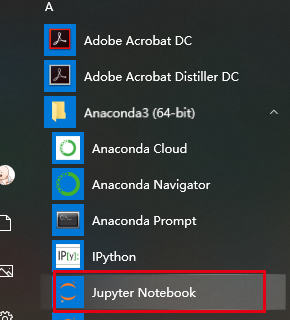

**Step 2**
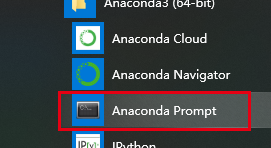

**Step 3**
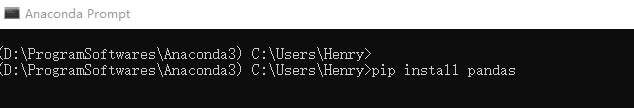

```
pip install numpy
pip install pandas
pip install pyspark
```

# 开发实战

## 数据集介绍

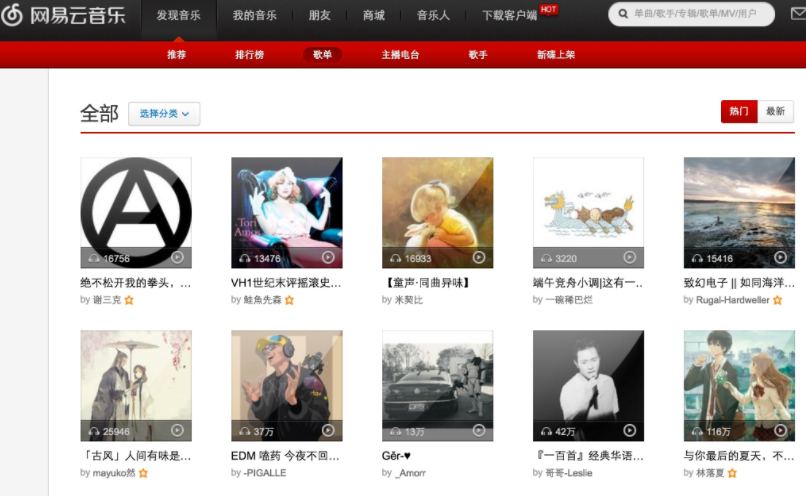

- 利用爬虫技术获取网易云音乐歌单，存储为json格式，用户收听曲目信息表：track.csv
- 歌曲 ID 对应歌曲标题：ID_index.csv

数据集大小：100万；
用户数：5000；
不重复音乐数：1700；
用户-音乐记录数：851475
<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th>Event ID</th>
    <th>Customer ID</th>
    <th>Track ID</th>
    <th>Datetime</th>
    <th>Mobile</th>
    <th>Listening Zip</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>Integer</td>
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>9999767</td>
    <td>2597</td>
    <td>788</td>
    <td>2014-12-01 09:54:09</td>
    <td>0</td>
    <td>11003</td>
  </tr>
</table>

## 导入 Spark、Python 相关包

In [6]:
# 相关模块导入
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col

from pyspark.mllib.recommendation import ALS, Rating, MatrixFactorizationModel
from pyspark.mllib.evaluation import RegressionMetrics

## 创建Spark会话，并加载数据

In [5]:
# 构建SparkSession实例对象
spark = SparkSession.builder.master("local[*]")\
        .appName("music-customer-analysis-with-pyspark").getOrCreate()

# 获取SparkContext实例对象
sc = spark.sparkContext

In [1]:
# 换成自己的文件路径，前面必须保留 file://
path = "file:///data/...."

In [7]:
# 创建数据模式，加载数据
music_schema = StructType([
        StructField('event_id', IntegerType(), nullable=True),
        StructField('customer_id', IntegerType(), nullable=True),
        StructField('track_id', IntegerType(), nullable=True),
        StructField('datetime', StringType(), nullable=True),
        StructField('is_mobile', IntegerType(), nullable=True),
        StructField('zip', IntegerType(), nullable=True)
])
music_df = spark.read.csv(path + 'data/tracks.csv', schema=music_schema, header=False)
music_df.createOrReplaceTempView("music")
music_df.registerTempTable("music")

In [11]:
# 读取 id - 标题映射
id_title_df = spark.read.csv(path=path + 'data/ID_index.csv', header=True)

## 数据观察

In [64]:
print(music_df.count())
music_df.show(5)

1000000
+--------+-----------+--------+-------------------+---------+-----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|
+--------+-----------+--------+-------------------+---------+-----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|
+--------+-----------+--------+-------------------+---------+-----+
only showing top 5 rows



In [90]:
id_title_df.show(3)

+--------+------------------------------------+
|track_id|                               Title|
+--------+------------------------------------+
|       1|  [华语私人订制] 最懂你的华语推荐...|
|       2|      先往前走，才会遇到自然而然的爱|
|       3|【中国摇滚】生活需要一张“自我”的门票|
+--------+------------------------------------+
only showing top 3 rows



## 数据预处理：获取输入数据集结构

In [89]:
# 构建（用户，音乐，收听次数）组合
spark.sql("select customer_id, track_id, count(*) as rating from music \
           group by customer_id, track_id \
           order by customer_id, count(*) desc").show(5)

+-----------+--------+------+
|customer_id|track_id|rating|
+-----------+--------+------+
|          0|       0|    93|
|          0|       1|    55|
|          0|       2|    53|
|          0|       4|    45|
|          0|       3|    41|
+-----------+--------+------+
only showing top 5 rows



In [91]:
id_title_dict = id_title_df.toPandas().set_index('track_id').T.to_dict('string')
id_title_dict["1"]["Title"]

'[华语私人订制] 最懂你的华语推荐 每日更新35首'

## 函数定义：模型训练函数和评估函数

In [66]:
# 定义函数，训练模型与模型评估
def train_model_evaluate(training_rdd, testing_rdd, rank, iterations, lambda_):
    # 使用超参数的值，训练数据和ALS算法训练模型
    model = ALS.train(training_rdd, rank, iterations, lambda_)

    # 模型的评估
    print('rank=%d, iterations=%d, lambda_=%f' % (rank, iterations, lambda_))
    rmse_value = alsModelEvaluate(model, testing_rdd)

    # 返回多元组
    return (model, rmse_value, rank, iterations, lambda_)

In [67]:
# 模型评估函数
def alsModelEvaluate(model, testing_rdd):
    # 针对测试数据集进行预测
    predict_rdd = model.predictAll(testing_rdd.map(lambda r: (r[0], r[1])))
    predict_actual_rdd = predict_rdd.map(lambda r: ((r[0], r[1]), r[2])) \
        .join(testing_rdd.map(lambda r: ((r[0], r[1]), r[2])))

    # 创建评估指标实例对象
    metrics = RegressionMetrics(predict_actual_rdd.map(lambda pr: pr[1]))
    print("MSE = %s" % metrics.meanSquaredError)
    print("RMSE = %s" % metrics.rootMeanSquaredError)

    # 返回均方根误差
    return metrics.rootMeanSquaredError

## 模型训练：超参数选择，最优模型

In [85]:
# 训练模型，并选择评估结果最好的模型
rawRatings = spark.sql("select customer_id, track_id, count(*) as rating from music \
           group by customer_id, track_id \
           order by customer_id, count(*) desc").rdd
ratings = rawRatings.map(lambda x: Rating(int(x[0]),int(x[1]),float(x[2])))
(training, test) = ratings.randomSplit([0.8, 0.2])

# ALS算法的超参数的调整（使用三层for循环，设置不同参数的值，分别使用ALS算法训练模型，评估获取RMSE的值）
metrix_list = [train_model_evaluate(training, test, param_rank, param_iterations, param_lambda)
               for param_rank in [10, 20]
               for param_iterations in [10, 20]
               for param_lambda in [0.01]]
sorted(metrix_list, key=lambda k: k[1], reverse=False)
model, rmse_value, rank, iterations, lambda_ = metrix_list[0]

print("The best parameters, rank=%s, iterations=%s, lambda_=%s" % (rank, iterations, lambda_))

rank=10, iterations=10, lambda_=0.010000
MSE = 0.27574475187878983
RMSE = 0.5251140370231878
rank=10, iterations=20, lambda_=0.010000
MSE = 0.2761292807463119
RMSE = 0.5254800479050673
rank=20, iterations=10, lambda_=0.010000
MSE = 0.28010858908862224
RMSE = 0.5292528593107667
rank=20, iterations=20, lambda_=0.010000
MSE = 0.2786156325076331
RMSE = 0.5278405370068058
The best parameters, rank=10, iterations=10, lambda_=0.01


## 用户和物品的特征因子矩阵

In [18]:
# 用户特征因子矩阵
user_feature_matrix = model.userFeatures()
print(user_feature_matrix.first())

(0, array('d', [1.6471097469329834, -0.3117137849330902, -4.307289123535156, 3.1464693546295166, 5.931401252746582, -10.277045249938965, 3.85221266746521, 1.3101555109024048, -3.010059356689453, -6.22345495223999]))


In [19]:
# 物品特征因子矩阵
item_feature_matrix = model.productFeatures()
print(item_feature_matrix.first())

(0, array('d', [3.2306551933288574, 0.12434926629066467, -0.11500093340873718, 2.008371591567993, 4.1348557472229, -4.137063503265381, -1.8059487342834473, -0.2989455759525299, -2.0229625701904297, -1.1922248601913452]))


## 使用模型进行推荐

### 基于用户的推荐

In [71]:
# 基于用户的推荐
userId, itemId, recNum = 0, 0, 5

In [76]:
# 为用户推荐音乐
topKRecs = model.recommendProducts(userId, recNum)
print('给用户%d推荐%d个喜欢的音乐：' % (userId, recNum))
for rec in topKRecs:
    print(rec, "Title:", id_title_dict[str(rec[1]+1)]['Title'])

给用户0推荐5个喜欢的音乐：
Rating(user=0, product=0, rating=85.29981293482335) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
Rating(user=0, product=1, rating=51.936578678767) Title: 先往前走，才会遇到自然而然的爱
Rating(user=0, product=2, rating=47.53721052950949) Title: 【中国摇滚】生活需要一张“自我”的门票
Rating(user=0, product=4, rating=44.620357284582894) Title: 精选丨超级温柔的男声
Rating(user=0, product=3, rating=38.658528359549564) Title: 饶 舌 情 歌


In [77]:
# 为音乐推荐用户
topKRecs = model.recommendUsers(itemId, recNum)
print('将音乐%d推荐给%d个喜欢它的用户：' % (itemId, recNum))
for rec in topKRecs:
    print(rec, "Title:", id_title_dict[str(rec[1]+1)]['Title'])

将音乐0推荐给5个喜欢它的用户：
Rating(user=0, product=0, rating=85.29981293482335) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
Rating(user=1, product=0, rating=46.17064078137212) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
Rating(user=4, product=0, rating=46.00416504816911) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
Rating(user=2, product=0, rating=42.343497779880146) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
Rating(user=14, product=0, rating=33.0004859161362) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首


In [78]:
# 预测某个用户对某个音乐的评分
print('给用户%d推荐音乐%d:%s的评分为:' % (userId, itemId, id_title_dict[str(rec[1]+1)]['Title']), model.predict(userId, itemId))

给用户0推荐音乐0:[华语私人订制] 最懂你的华语推荐 每日更新35首的评分为: 85.29981293482335


### 基于物品的推荐

In [80]:
# 基于物品的推荐
def cosineSImilarity(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

<span class="girk">Todo</span>

In [82]:
itemId, recNum = 0, 5
# Todo
itemFactor = pass

In [84]:
#计算该商品与其他所有商品的余弦相似度
sims = model.productFeatures().map(lambda line:\
       (line[0], cosineSImilarity(np.array(line[1]), np.array(itemFactor))))
simItem = sims.sortBy(lambda line:line[1],ascending=False).collect()

print('与音乐%d相似的前%d个音乐是：' % (itemId, recNum))
for i in simItem[:recNum]:
    print(i, "Title:", id_title_dict[str(i[0]+1)]['Title'])

与音乐0相似的前5个音乐是：
(0, 1.0) Title: [华语私人订制] 最懂你的华语推荐 每日更新35首
(64, 0.7496784378409226) Title: 二十岁后的人生像是按了加快键
(74, 0.6771033760327494) Title: Hiphop说唱宝藏库
(21, 0.6315647735878569) Title: 失恋必听：你是我绕不开的回忆
(29, 0.631035522875304) Title: 中国新生代 | 那些崛起的说唱后浪们


## 模型保存与加载

In [69]:
# 保存模型
model.save(sc, path+"model/als_model")

# 加载模型
model = MatrixFactorizationModel.load(sc, path+"model/als_model")